In [11]:
import numpy as np
import pandas as pd
from neural_network.layer import DenseLayer
from neural_network.activation import Sigmoid
from neural_network.loss import MSE, RMSE, MAE, Error
from neural_network.optimizer import SgdMomentum
from utils import *

In [12]:
df = load_data('data/data_195k.csv')

# split the data, with 70% training data, 15 each for validation and testing data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, train_split_ratio=0.7, val_split_ratio=0.15)
(X_train.shape, X_val.shape, X_test.shape), (y_train.shape, y_val.shape, y_test.shape)

(((136598, 2), (29271, 2), (29272, 2)), ((136598, 2), (29271, 2), (29272, 2)))

In [13]:
class NeuralNetwork:
    '''
    Implementation of MLP/Neural Network Architecture.
    Constructor: Initialize the layers, multiple loss functions, and gradients of our loss function
    Forward Method: Iterates over all the layers and call the forward method of each object
    Backward Method: Similar to backward method, iterates over all the layers in reverse and calls the backward method
    Forward Pass: Calls the forward method, after receiving the output, calculates multiple losses and returns the output and loss
    Backward Pass: Calls the backward method, for backward pass 
    '''
    def __init__(self, layers, loss, mse, rmse):
        self.layers = layers
        self.loss_function = loss
        self.mse = mse
        self.rmse = rmse
        self.grad_loss = None

    def forward(self, input_data):
        output = input_data
        # iterating over all the layers to call the forward method of layer/activation
        for layer in self.layers:
            output = layer.forward(output)
        return output
        
    def backward(self, grad_output):
        # iterating over all the layers in reverse to call the backward method of layer/activation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
            
    def forward_pass(self, input_data, target):
        output = self.forward(input_data) # call the forward method
        _, grad_loss = self.loss_function.forward(target, output) # calculate the error
        self.grad_loss = grad_loss # receives the gradient
        mse_err = self.mse.forward(target, output) # calculate mse
        rmse_err = self.rmse.forward(target, output) # calculate rmse
        return (mse_err, rmse_err), output # return mse, rmse and output of final layer
        
    def backward_pass(self):
        self.backward(self.grad_loss) # call the backward method with the grad_loss

In [14]:
def stopping_criterion(val_loss):
    '''
    The stopping criterion is rather simpler
    If the last three epochs of our RMSE loss upto 5 decimal places are equal, stop the training
    and save the weights by returning key words 'stop', 'continue'
    '''
    format_loss = [format(num, '.5f') for num in val_loss]

    if format_loss[0] == format_loss[1] == format_loss[2]:
        return 'stop'
    elif format_loss[0] < format_loss[1] < format_loss[2]:
        return 'stop'
    else:
        'continue'
    

### Grid Search

In [8]:
from itertools import product

lr = [0.001, 0.1, 0.25, 0.5, 0.8, 1]
momentum = [0.1, 0.5, 0.9]
hidden_neurons = [2,5,10,15]

# calculating different types of combinations (72) and storing it in a dictionary, to assess which model performs the best
combinations = list(product(lr, momentum, hidden_neurons))
grid_search = dict()
# combinations

In [9]:
# iterate over all the combinations
for i in range(len(combinations)):
    # set the current combination of lr, momentum and hidden neurons
    learning_rate = combinations[i][0]
    momentum = combinations[i][1]
    hidden_neurons = combinations[i][2]
    
    # initialize the epochs, loss, optimizer
    epochs = 20
    loss = Error()
    mse = MSE()
    rmse = RMSE()
    optim = SgdMomentum(lr=learning_rate, beta=momentum)

    # initialize the layers
    dense_layer = DenseLayer(2, hidden_neurons, weights_init='default')  
    activation_hidden = Sigmoid()
    output_layer = DenseLayer(hidden_neurons, 2, weights_init='default') 
    activation_output = Sigmoid()

    # pass the objects of layers, activation, loss to Network constructor, which stores it there 
    network = NeuralNetwork(
        [dense_layer, 
         activation_hidden, 
         output_layer, 
         activation_output], 
        loss, mse, rmse)

    # initialize empty strings, for keeping track of training/validation losses of mse and rmse 
    t_loss_mse = []
    v_loss_mse = []
    t_loss_rmse = []
    v_loss_rmse = []

    # Run the network for n epochs
    for epoch in range(epochs):
        # these variables are zero, for each epoch they are accumulated and in the end divided by len of training data
        # this gives the average mse/rmse loss for that epoch, we will append that single value of epoch to our list
        total_train_loss_mse = 0
        total_val_loss_mse = 0
        total_train_loss_rmse = 0
        total_val_loss_rmse = 0

        # Iterate over the training data
        for i in range(len(X_train)):
            # convert 1D input to 2D input, also convert it to floating points
            input_data = np.array(np.expand_dims(X_train[i], axis=0), dtype=np.float32)
            target = np.array(y_train[i], dtype=np.float32)

            # pass the inputs to forward pass of network
            mse_rmse_loss, _ = network.forward_pass(input_data, target)

            # adding up the mse and rmse loss after each row of training data
            total_train_loss_mse += mse_rmse_loss[0]
            total_train_loss_rmse += mse_rmse_loss[1][0] # input data is 2d so rmse returns in a 1D list, just fetching the value [0]

            # calculate the backward pass
            network.backward_pass()

            # calculate velocities of each parameter and update the params
            optim.calculate((dense_layer.dw, output_layer.dw, dense_layer.db, output_layer.db))
            optim.update(vars(dense_layer), vars(output_layer))

        # Just like training, iterate over validation set
        for j in range(len(X_val)):
            # convert inputs from 1D to 2D, and also converts to floating points
            val_input_data = np.array(np.expand_dims(X_val[j], axis=0), dtype=np.float32)
            val_target_output = np.array(y_val[j], dtype=np.float32)

            # forward pass the network on validation data
            mse_rmse_loss_val, output = network.forward_pass(val_input_data, val_target_output)

            # adding up the mse and rmse loss after each row of validation data
            total_val_loss_mse += mse_rmse_loss_val[0]
            total_val_loss_rmse += mse_rmse_loss_val[1][0]


        # Just calculating the average of accumlated mse/rmse losses and appending in a list to plot it later on
        t_loss_mse.append(total_train_loss_mse/len(X_train))
        v_loss_mse.append(total_val_loss_mse/len(X_val))

        t_loss_rmse.append(total_train_loss_rmse/len(X_train))
        v_loss_rmse.append(total_val_loss_rmse/len(X_val))

    
    # printing the last (epoch) loss of each combination
    print(f'lr_{learning_rate}_momentum_{momentum}_h_neurons_{hidden_neurons}: T_MSE Avg Loss: {(total_train_loss_mse/len(X_train)):.6f}, V_MSE Avg Loss: {(total_val_loss_mse/len(X_val)):.6f}, T_RMSE Avg Loss: {(total_train_loss_rmse/len(X_train)):.6f}, V_RMSE Avg Loss: {(total_val_loss_rmse/len(X_val)):.6f}')
    key = f'lr_{learning_rate}_momentum_{momentum}_h_neurons_{hidden_neurons}'
    
    # append the last mse/rmse loss to the dictionary (assuming it to be the best)
    grid_search[key] = {'train_mse_loss': total_train_loss_mse/len(X_train),
                        'validation_mse_loss': total_val_loss_mse/len(X_val),
                        'train_rmse_loss': total_train_loss_rmse/len(X_train),
                        'validation_rmse_loss': total_val_loss_rmse/len(X_val)}

lr_0.001_momentum_0.1_h_neurons_2: T_MSE Avg Loss: 0.011297, V_MSE Avg Loss: 0.011378, T_RMSE Avg Loss: 0.082664, V_RMSE Avg Loss: 0.082793
lr_0.001_momentum_0.1_h_neurons_5: T_MSE Avg Loss: 0.011270, V_MSE Avg Loss: 0.011350, T_RMSE Avg Loss: 0.082600, V_RMSE Avg Loss: 0.082722
lr_0.001_momentum_0.1_h_neurons_10: T_MSE Avg Loss: 0.011188, V_MSE Avg Loss: 0.011265, T_RMSE Avg Loss: 0.082344, V_RMSE Avg Loss: 0.082453
lr_0.001_momentum_0.1_h_neurons_15: T_MSE Avg Loss: 0.011168, V_MSE Avg Loss: 0.011242, T_RMSE Avg Loss: 0.082331, V_RMSE Avg Loss: 0.082431
lr_0.001_momentum_0.5_h_neurons_2: T_MSE Avg Loss: 0.011212, V_MSE Avg Loss: 0.011287, T_RMSE Avg Loss: 0.082461, V_RMSE Avg Loss: 0.082575
lr_0.001_momentum_0.5_h_neurons_5: T_MSE Avg Loss: 0.011186, V_MSE Avg Loss: 0.011258, T_RMSE Avg Loss: 0.082389, V_RMSE Avg Loss: 0.082489
lr_0.001_momentum_0.5_h_neurons_10: T_MSE Avg Loss: 0.011044, V_MSE Avg Loss: 0.011107, T_RMSE Avg Loss: 0.081880, V_RMSE Avg Loss: 0.081943
lr_0.001_momentum

lr_0.8_momentum_0.9_h_neurons_15: T_MSE Avg Loss: 0.009653, V_MSE Avg Loss: 0.008492, T_RMSE Avg Loss: 0.081298, V_RMSE Avg Loss: 0.075006
lr_1_momentum_0.1_h_neurons_2: T_MSE Avg Loss: 0.008446, V_MSE Avg Loss: 0.008295, T_RMSE Avg Loss: 0.075170, V_RMSE Avg Loss: 0.074727
lr_1_momentum_0.1_h_neurons_5: T_MSE Avg Loss: 0.008342, V_MSE Avg Loss: 0.008177, T_RMSE Avg Loss: 0.074667, V_RMSE Avg Loss: 0.074134
lr_1_momentum_0.1_h_neurons_10: T_MSE Avg Loss: 0.008321, V_MSE Avg Loss: 0.008142, T_RMSE Avg Loss: 0.074559, V_RMSE Avg Loss: 0.073883
lr_1_momentum_0.1_h_neurons_15: T_MSE Avg Loss: 0.008294, V_MSE Avg Loss: 0.008126, T_RMSE Avg Loss: 0.074358, V_RMSE Avg Loss: 0.073670
lr_1_momentum_0.5_h_neurons_2: T_MSE Avg Loss: 0.008634, V_MSE Avg Loss: 0.008237, T_RMSE Avg Loss: 0.076159, V_RMSE Avg Loss: 0.074325
lr_1_momentum_0.5_h_neurons_5: T_MSE Avg Loss: 0.008486, V_MSE Avg Loss: 0.008118, T_RMSE Avg Loss: 0.075421, V_RMSE Avg Loss: 0.073593
lr_1_momentum_0.5_h_neurons_10: T_MSE Avg L

In [10]:
# import json

# # save the dictionary for grid search
# with open('grid_search_72.json', 'w') as fp:
#     json.dump(grid_search, fp)

In [2]:
# # can open and check the saved dictionary 
# with open('grid_search_72.json') as f:
#     d = json.load(f)

### Code

In [15]:
# try the best combination, retrieved from grid search
epochs = 20
loss = Error()
mse = MSE()
rmse = RMSE()
optim = SgdMomentum(lr=0.8, beta=0.1)
s_criterion = None

# initialization of layers, activation and network
dense_layer = DenseLayer(2, 15, weights_init='default')  
activation_hidden = Sigmoid()
output_layer = DenseLayer(15, 2, weights_init='default') 
activation_output = Sigmoid()

network = NeuralNetwork(
    [dense_layer, 
     activation_hidden, 
     output_layer, 
     activation_output], 
    loss, mse, rmse)

# per epoch lists of mse and rmse
t_loss_mse = []
v_loss_mse = []
t_loss_rmse = []
v_loss_rmse = []

for epoch in range(epochs):
    # initialize the variables for add up the loss of each row, divide it by length at the end to receive average
    total_train_loss_mse = 0
    total_val_loss_mse = 0
    total_train_loss_rmse = 0
    total_val_loss_rmse = 0
    
    for i in range(len(X_train)):
        input_data = np.array(np.expand_dims(X_train[i], axis=0), dtype=np.float32)
        target = np.array(y_train[i], dtype=np.float32)

        mse_rmse_loss, _ = network.forward_pass(input_data, target)
        
        # adding up the mse and rmse loss after each row of training data
        total_train_loss_mse += mse_rmse_loss[0]
        total_train_loss_rmse += mse_rmse_loss[1][0] # input data is 2d so rmse returns in a 1D list, just fetching the value [0]
        
        network.backward_pass()
        
        # updating weights
        optim.calculate((dense_layer.dw, output_layer.dw, dense_layer.db, output_layer.db))
        optim.update(vars(dense_layer), vars(output_layer))
        
    for j in range(len(X_val)):
        val_input_data = np.array(np.expand_dims(X_val[j], axis=0), dtype=np.float32)
        val_target_output = np.array(y_val[j], dtype=np.float32)

        mse_rmse_loss_val, output = network.forward_pass(val_input_data, val_target_output)
        
        # add up the mse and rmse loss after each row of validation data
        total_val_loss_mse += mse_rmse_loss_val[0]
        total_val_loss_rmse += mse_rmse_loss_val[1][0]
    
    
    # Just calculating the average of accumlated mse/rmse losses and appending in a list to plot it later on
    t_loss_mse.append(total_train_loss_mse/len(X_train))
    v_loss_mse.append(total_val_loss_mse/len(X_val))
    
    t_loss_rmse.append(total_train_loss_rmse/len(X_train))
    v_loss_rmse.append(total_val_loss_rmse/len(X_val))
    
    # Plot the average mse and rmse loss each epoch
    print(f'Epoch: {epoch+1}, T_MSE Avg Loss: {(total_train_loss_mse/len(X_train)):.6f}, V_MSE Avg Loss: {(total_val_loss_mse/len(X_val)):.6f}, T_RMSE Avg Loss: {(total_train_loss_rmse/len(X_train)):.6f}, V_RMSE Avg Loss: {(total_val_loss_rmse/len(X_val)):.6f}')
    
    # calling the stopping criterion, and passing atleast 3 values of rmse validation loss  
    if len(v_loss_rmse) >= 3:
        s_criterion = stopping_criterion(v_loss_rmse[-3:])
    
    # if flag == stop then stop the training, else continue
    if s_criterion == 'stop':
        print('Stopping!')
        break
    else:
        continue

Epoch: 1, T_MSE Avg Loss: 0.009682, V_MSE Avg Loss: 0.008995, T_RMSE Avg Loss: 0.080189, V_RMSE Avg Loss: 0.077697
Epoch: 2, T_MSE Avg Loss: 0.008913, V_MSE Avg Loss: 0.008701, T_RMSE Avg Loss: 0.077321, V_RMSE Avg Loss: 0.076443
Epoch: 3, T_MSE Avg Loss: 0.008765, V_MSE Avg Loss: 0.008636, T_RMSE Avg Loss: 0.076491, V_RMSE Avg Loss: 0.076063
Epoch: 4, T_MSE Avg Loss: 0.008711, V_MSE Avg Loss: 0.008588, T_RMSE Avg Loss: 0.076186, V_RMSE Avg Loss: 0.075820
Epoch: 5, T_MSE Avg Loss: 0.008661, V_MSE Avg Loss: 0.008522, T_RMSE Avg Loss: 0.075932, V_RMSE Avg Loss: 0.075516
Epoch: 6, T_MSE Avg Loss: 0.008574, V_MSE Avg Loss: 0.008403, T_RMSE Avg Loss: 0.075543, V_RMSE Avg Loss: 0.075026
Epoch: 7, T_MSE Avg Loss: 0.008464, V_MSE Avg Loss: 0.008306, T_RMSE Avg Loss: 0.075129, V_RMSE Avg Loss: 0.074730
Epoch: 8, T_MSE Avg Loss: 0.008403, V_MSE Avg Loss: 0.008263, T_RMSE Avg Loss: 0.074942, V_RMSE Avg Loss: 0.074615
Epoch: 9, T_MSE Avg Loss: 0.008372, V_MSE Avg Loss: 0.008239, T_RMSE Avg Loss: 0

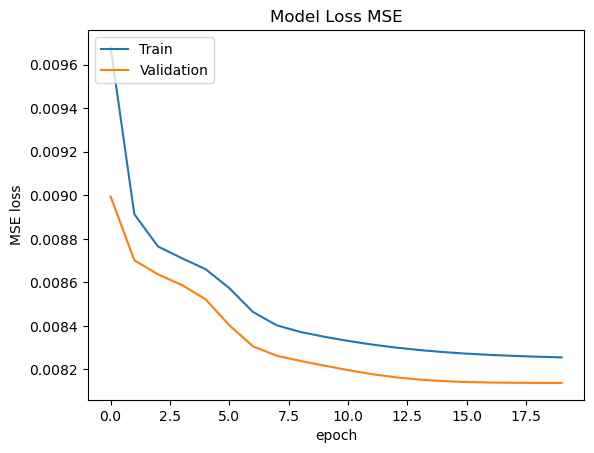

In [16]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(t_loss_mse)
plt.plot(v_loss_mse)
plt.title('Model Loss MSE')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

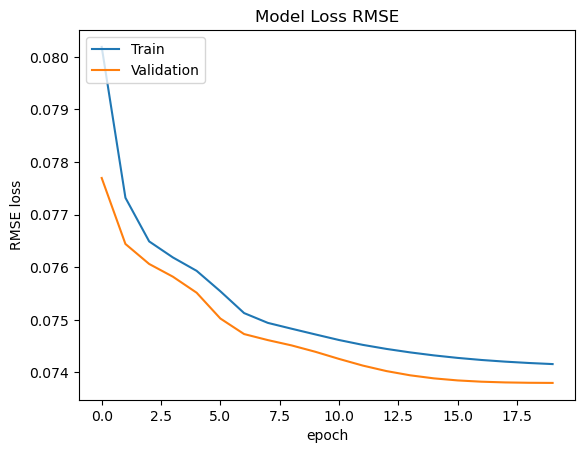

In [17]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(t_loss_rmse)
plt.plot(v_loss_rmse)
plt.title('Model Loss RMSE')
plt.ylabel('RMSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Trying another combination of hyperparameters

In [12]:
# try the best combination, retrieved from grid search
epochs = 100
loss = Error()
mse = MSE()
rmse = RMSE()
optim = SgdMomentum(lr=0.25, beta=0.9)
s_criterion = None

dense_layer = DenseLayer(2, 15, weights_init='default')  
activation_hidden = Sigmoid()
output_layer = DenseLayer(15, 2, weights_init='default') 
activation_output = Sigmoid()

network = NeuralNetwork(
    [dense_layer, 
     activation_hidden, 
     output_layer, 
     activation_output], 
    loss, mse, rmse)

t_loss_mse = []
v_loss_mse = []
t_loss_rmse = []
v_loss_rmse = []

for epoch in range(epochs):
    total_train_loss_mse = 0
    total_val_loss_mse = 0
    total_train_loss_rmse = 0
    total_val_loss_rmse = 0
    
    for i in range(len(X_train)):
        input_data = np.array(np.expand_dims(X_train[i], axis=0), dtype=np.float32)
        target = np.array(y_train[i], dtype=np.float32)

        mse_rmse_loss, _ = network.forward_pass(input_data, target)
        
        # add up the mse and rmse loss after each row of training data
        total_train_loss_mse += mse_rmse_loss[0]
        total_train_loss_rmse += mse_rmse_loss[1][0] # input data is 2d so rmse returns in a 1D list, just fetching the value [0]
        
        network.backward_pass()
        
        optim.calculate((dense_layer.dw, output_layer.dw, dense_layer.db, output_layer.db))
        optim.update(vars(dense_layer), vars(output_layer))
        
    for j in range(len(X_val)):
        val_input_data = np.array(np.expand_dims(X_val[j], axis=0), dtype=np.float32)
        val_target_output = np.array(y_val[j], dtype=np.float32)

        mse_rmse_loss_val, output = network.forward_pass(val_input_data, val_target_output)
        
        # accumulative the mse and rmse loss after each row of validation data
        total_val_loss_mse += mse_rmse_loss_val[0]
        total_val_loss_rmse += mse_rmse_loss_val[1][0]
    
    
    # Just calculating the average of accumlated mse/rmse losses and appending in a list to plot it later on
    t_loss_mse.append(total_train_loss_mse/len(X_train))
    v_loss_mse.append(total_val_loss_mse/len(X_val))
    
    t_loss_rmse.append(total_train_loss_rmse/len(X_train))
    v_loss_rmse.append(total_val_loss_rmse/len(X_val))
    
    # Plot the average mse and rmse loss each epoch
    print(f'Epoch: {epoch+1}, T_MSE Avg Loss: {(total_train_loss_mse/len(X_train)):.6f}, V_MSE Avg Loss: {(total_val_loss_mse/len(X_val)):.6f}, T_RMSE Avg Loss: {(total_train_loss_rmse/len(X_train)):.6f}, V_RMSE Avg Loss: {(total_val_loss_rmse/len(X_val)):.6f}')
    
    if len(v_loss_rmse) >= 3:
        s_criterion = stopping_criterion(v_loss_rmse[-3:])
    
    if s_criterion == 'stop':
        print('Stopping!')
        break
    else:
        continue

Epoch: 1, T_MSE Avg Loss: 0.009403, V_MSE Avg Loss: 0.008620, T_RMSE Avg Loss: 0.079528, V_RMSE Avg Loss: 0.075736
Epoch: 2, T_MSE Avg Loss: 0.009023, V_MSE Avg Loss: 0.008579, T_RMSE Avg Loss: 0.077852, V_RMSE Avg Loss: 0.075582
Epoch: 3, T_MSE Avg Loss: 0.008981, V_MSE Avg Loss: 0.008553, T_RMSE Avg Loss: 0.077593, V_RMSE Avg Loss: 0.075412
Epoch: 4, T_MSE Avg Loss: 0.008942, V_MSE Avg Loss: 0.008463, T_RMSE Avg Loss: 0.077425, V_RMSE Avg Loss: 0.074873
Epoch: 5, T_MSE Avg Loss: 0.008831, V_MSE Avg Loss: 0.008302, T_RMSE Avg Loss: 0.076981, V_RMSE Avg Loss: 0.074155
Epoch: 6, T_MSE Avg Loss: 0.008731, V_MSE Avg Loss: 0.008233, T_RMSE Avg Loss: 0.076624, V_RMSE Avg Loss: 0.073978
Epoch: 7, T_MSE Avg Loss: 0.008675, V_MSE Avg Loss: 0.008193, T_RMSE Avg Loss: 0.076427, V_RMSE Avg Loss: 0.073825
Epoch: 8, T_MSE Avg Loss: 0.008637, V_MSE Avg Loss: 0.008161, T_RMSE Avg Loss: 0.076254, V_RMSE Avg Loss: 0.073641
Epoch: 9, T_MSE Avg Loss: 0.008614, V_MSE Avg Loss: 0.008145, T_RMSE Avg Loss: 0

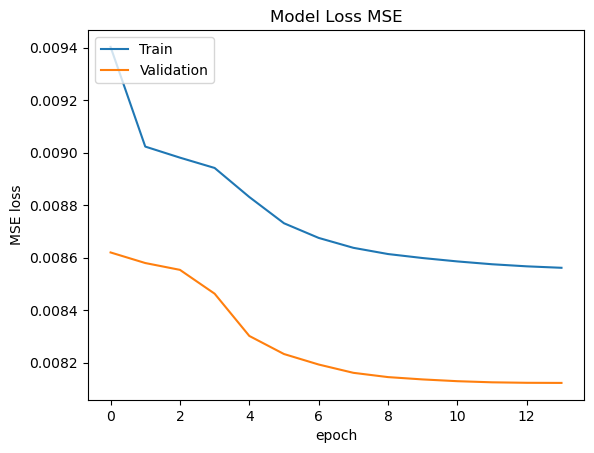

In [13]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(t_loss_mse)
plt.plot(v_loss_mse)
plt.title('Model Loss MSE')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

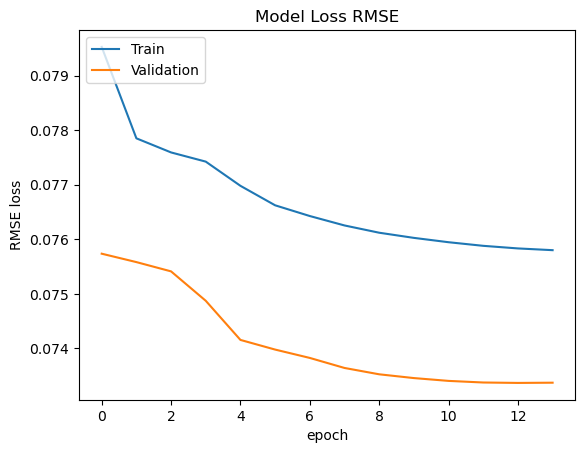

In [14]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(t_loss_rmse)
plt.plot(v_loss_rmse)
plt.title('Model Loss RMSE')
plt.ylabel('RMSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# # save the weights
# np.savez('weights/grid_search_1.npz', 
#          weights_input_hidden=dense_layer.w,
#          bias_hidden=dense_layer.b,
#          weights_hidden_output=output_layer.w,
#          bias_output=output_layer.b)